In [2]:
import os
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt
import datetime
from glob import glob
from PIL import Image

In [19]:
# Configuration parameters
BATCH_SIZE = 8  # Small batch size to save memory
IMAGE_SIZE = 128  # Reduced from 512 to save memory
CHANNELS = 3
EPOCHS = 50
NOISE_DIM = 100
NUM_EXAMPLES_TO_GENERATE = 16
BUFFER_SIZE = 1000  # For dataset shuffling
NOISE_FACTOR = 0.05  # Factor for input noise to discriminator

In [20]:
DATA_DIR = '/kaggle/input/gananime-lite/out2'
# Create directories for saving results
os.makedirs('results', exist_ok=True)
os.makedirs('checkpoints', exist_ok=True)

### **data loading and preprocessing**

In [21]:
def load_and_preprocess_data(data_dir, image_size, batch_size, buffer_size):
    # Get list of image files
    image_files = glob(os.path.join(data_dir, '*.png'))
    print(f"Found {len(image_files)} images in {data_dir}")
    
    # Create a dataset from the image files
    dataset = tf.data.Dataset.from_tensor_slices(image_files)
    
    # Load and preprocess images
    def preprocess_image(file_path):
        # Read the image file
        img = tf.io.read_file(file_path)
        # Decode PNG
        img = tf.image.decode_png(img, channels=CHANNELS)
        # Resize
        img = tf.image.resize(img, [image_size, image_size])
        # Normalize to [-1, 1]
        img = (tf.cast(img, tf.float32) - 127.5) / 127.5
        return img
    
    # Map preprocessing function to dataset
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    
    # Shuffle, batch, and prefetch for better performance
    dataset = dataset.shuffle(buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

### **generator model**

In [22]:
def make_generator_model(noise_dim):
    # Starting size is 8x8 (will be upscaled to 128x128)
    starting_size = IMAGE_SIZE // 16
    
    model = models.Sequential([
        # Input layer
        layers.Dense(starting_size * starting_size * 512, use_bias=False, input_shape=(noise_dim,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((starting_size, starting_size, 512)),
        
        # Upsampling layers
        # 8x8 -> 16x16
        layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        
        # 16x16 -> 32x32
        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        
        # 32x32 -> 64x64
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        
        # 64x64 -> 128x128
        layers.Conv2DTranspose(CHANNELS, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    
    return model

### **discriminator model**

In [23]:
def make_discriminator_model():
    model = models.Sequential([
        # 128x128 -> 64x64
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[IMAGE_SIZE, IMAGE_SIZE, CHANNELS]),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        
        # 64x64 -> 32x32
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        
        # 32x32 -> 16x16
        layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        
        # 16x16 -> 8x8
        layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        
        # Flatten and output
        layers.Flatten(),
        layers.Dense(1)
    ])
    
    return model

In [24]:
# Add noise to images for discriminator
def add_noise(images, noise_factor=NOISE_FACTOR):
    noise = tf.random.normal(shape=tf.shape(images), mean=0.0, stddev=noise_factor)
    noisy_images = images + noise
    # Clip to ensure values remain in [-1, 1]
    return tf.clip_by_value(noisy_images, -1.0, 1.0)

### **Loss functions**

In [25]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) # we use from_logits=True because the output of the discriminator is not normalized (like we have not used sigmoid function there)

In [26]:
# Discriminator loss
def discriminator_loss(real_output, fake_output):
    # Label smoothing: use 0.9 instead of 1.0 for real images
    real_labels = tf.ones_like(real_output) * 0.9
    fake_labels = tf.zeros_like(fake_output)
    
    real_loss = cross_entropy(real_labels, real_output)
    fake_loss = cross_entropy(fake_labels, fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Generator loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [27]:
# Optimizers with different learning rates
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.5)

In [28]:
# Create the models
generator = make_generator_model(NOISE_DIM)
discriminator = make_discriminator_model()

# Checkpoint for saving model
checkpoint_prefix = os.path.join('checkpoints', 'ckpt')
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator
)

In [29]:
# Generate and save images
def generate_and_save_images(model, epoch, test_input):
    # Generate images from the model
    predictions = model(test_input, training=False)

    # Rescale to [0, 1] and convert to numpy array with float32 dtype
    predictions = (predictions * 0.5) + 0.5
    predictions = tf.cast(predictions, tf.float32)
    predictions = predictions.numpy()

    # Ensure values are in valid range for imshow
    predictions = np.clip(predictions, 0.0, 1.0)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i])
        plt.axis('off')

    plt.savefig(f'results/image_at_epoch_{epoch:04d}.png')
    plt.close()

### **Training step**

In [30]:
# Training step with balanced updates and noise addition
@tf.function
def train_step(images):
    # Generate random noise for the generator
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
    
    # Train discriminator
    with tf.GradientTape() as disc_tape:
        # Generate fake images
        generated_images = generator(noise, training=True)
        
        # Add noise to both real and fake images
        noisy_real_images = add_noise(images)
        noisy_fake_images = add_noise(generated_images)
        
        # Get discriminator outputs for real and fake images
        real_output = discriminator(noisy_real_images, training=True)
        fake_output = discriminator(noisy_fake_images, training=True)
        
        # Calculate discriminator loss
        disc_loss = discriminator_loss(real_output, fake_output)
    
    # Calculate and apply discriminator gradients
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    # Clip gradients for stability
    gradients_of_discriminator, _ = tf.clip_by_global_norm(gradients_of_discriminator, 1.0)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    # Train generator twice to balance training
    gen_loss_total = 0
    for _ in range(2):  # Train generator twice for each discriminator update
        noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
        
        with tf.GradientTape() as gen_tape:
            # Generate fake images
            generated_images = generator(noise, training=True)
            
            # Get discriminator output for fake images (no noise for generator training)
            fake_output = discriminator(generated_images, training=True)
            
            # Calculate generator loss
            gen_loss = generator_loss(fake_output)
            gen_loss_total += gen_loss
        
        # Calculate and apply generator gradients
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        # Clip gradients for stability
        gradients_of_generator, _ = tf.clip_by_global_norm(gradients_of_generator, 1.0)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
    gen_loss_avg = gen_loss_total / 2
    
    return gen_loss_avg, disc_loss

### **Training function**

In [34]:
# Training function with progress reporting
def train(dataset, epochs):
    # Create fixed noise for image generation
    seed = tf.random.normal([NUM_EXAMPLES_TO_GENERATE, NOISE_DIM])
    
    # For each epoch
    for epoch in range(epochs):
        start = time.time()
        
        # Initialize epoch loss accumulators
        epoch_gen_loss = 0
        epoch_disc_loss = 0
        num_batches = 0
        
        # Calculate total batches for progress reporting
        total_batches = tf.data.experimental.cardinality(dataset).numpy()
        if total_batches < 0:  # If cardinality is unknown
            total_batches = "?"
        
        # For each batch in the dataset
        for i, image_batch in enumerate(dataset):
            # Train on batch
            gen_loss, disc_loss = train_step(image_batch)
            
            # Accumulate losses
            epoch_gen_loss += gen_loss
            epoch_disc_loss += disc_loss
            num_batches += 1
            
        
        # Calculate average losses
        epoch_gen_loss /= num_batches
        epoch_disc_loss /= num_batches
        
        # Generate and save images
        if (epoch + 1) % 5 == 0 or epoch == 0:
            generate_and_save_images(generator, epoch + 1, seed)
        
        # Save the model every 10 epochs
        if (epoch + 1) % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            
            # Optional: Clear session to free up memory after checkpoint save
            if epoch > 20:  # Only do this after some training has happened
                tf.keras.backend.clear_session()
                # Rebuild the models from the checkpoint
                checkpoint.restore(tf.train.latest_checkpoint('checkpoints'))
        
        # Print epoch stats
        print(f'Epoch {epoch+1}/{epochs}, Gen Loss: {epoch_gen_loss:.4f}, Disc Loss: {epoch_disc_loss:.4f}, Time: {time.time()-start:.2f} sec')
        
        # Early stopping if training becomes unstable
        if epoch > 5 and (epoch_gen_loss > 10 or epoch_disc_loss < 0.05):
            print("Training becoming unstable. Adjusting learning rates...")
            # Reduce learning rates
            generator_optimizer.learning_rate = generator_optimizer.learning_rate * 0.5
            discriminator_optimizer.learning_rate = discriminator_optimizer.learning_rate * 0.5
            print(f"New learning rates - Generator: {generator_optimizer.learning_rate.numpy()}, Discriminator: {discriminator_optimizer.learning_rate.numpy()}")
    
    # Generate a final set of images
    generate_and_save_images(generator, epochs, seed)

### **Main function**

In [32]:
def main():
    # Load and preprocess data
    dataset = load_and_preprocess_data(DATA_DIR, IMAGE_SIZE, BATCH_SIZE, BUFFER_SIZE)
    
    # Print model summaries
    print("Generator Model Summary:")
    generator.summary()
    
    print("\nDiscriminator Model Summary:")
    discriminator.summary()
    
    # Train the model
    print("\nStarting training...")
    train(dataset, EPOCHS)
    
    # Save the final model
    generator.save('anime_generator_model')
    discriminator.save('anime_discriminator_model')
    
    print("Training completed and models saved!")

In [35]:
if __name__ == "__main__":
    main()

Found 25663 images in /kaggle/input/gananime-lite/out2
Generator Model Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                      │ (None, 32768)               │       3,276,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32768)               │         131,072 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 16, 16, 256)         │       3,276,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_9 (LeakyReLU)            │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 32, 32, 128)         │         819,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_10 (LeakyReLU)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_6 (Conv2DTranspose) │ (None, 64, 64, 64)          │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_11 (LeakyReLU)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_7 (Conv2DTranspose) │ (None, 128, 128, 3)         │           4,800 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,715,264 (29.43 MB)

 Trainable params: 7,648,832 (29.18 MB)

 Non-trainable params: 66,432 (259.50 KB)


Discriminator Model Summary:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 64)          │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_12 (LeakyReLU)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_13 (LeakyReLU)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 16, 16, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_14 (LeakyReLU)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 8, 8, 512)           │       3,277,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_15 (LeakyReLU)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │          32,769 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,339,329 (16.55 MB)

 Trainable params: 4,339,329 (16.55 MB)

 Non-trainable params: 0 (0.00 B)


Starting training...


E0000 00:00:1745734515.900502      31 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3_1/dropout_4_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 1/50, Gen Loss: 0.7902, Disc Loss: 1.3874, Time: 206.86 sec
Epoch 2/50, Gen Loss: 0.8299, Disc Loss: 1.3754, Time: 199.10 sec
Epoch 3/50, Gen Loss: 1.0123, Disc Loss: 1.2560, Time: 198.84 sec
Epoch 4/50, Gen Loss: 1.0975, Disc Loss: 1.2018, Time: 198.77 sec
Epoch 5/50, Gen Loss: 0.9522, Disc Loss: 1.2201, Time: 198.99 sec
Epoch 6/50, Gen Loss: 0.8327, Disc Loss: 1.2207, Time: 199.23 sec
Epoch 7/50, Gen Loss: 0.8091, Disc Loss: 1.1888, Time: 202.20 sec
Epoch 8/50, Gen Loss: 0.8234, Disc Loss: 1.1373, Time: 204.21 sec
Epoch 9/50, Gen Loss: 0.8447, Disc Loss: 1.0874, Time: 200.27 sec
Epoch 10/50, Gen Loss: 0.8790, Disc Loss: 1.0507, Time: 199.53 sec
Epoch 11/50, Gen Loss: 0.9211, Disc Loss: 1.0130, Time: 201.98 sec
Epoch 12/50, Gen Loss: 0.9662, Disc Loss: 0.9730, Time: 205.36 sec
Epoch 13/50, Gen Loss: 1.0076, Disc Loss: 0.9444, Time: 202.06 sec
Epoch 14/50, Gen Loss: 1.0817, Disc Loss: 0.9177, Time: 198.93 sec
Epoch 15/50, Gen Loss: 1.1111, Disc Loss: 0.8892, Time: 199.46 sec
Epoc

E0000 00:00:1745740323.820732      31 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3_1/dropout_4_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
E0000 00:00:1745740519.489125      31 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3_1/dropout_4_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 31/50, Gen Loss: 1.4930, Disc Loss: 0.7018, Time: 199.34 sec
Epoch 32/50, Gen Loss: 1.4758, Disc Loss: 0.6935, Time: 197.99 sec
Epoch 33/50, Gen Loss: 1.5386, Disc Loss: 0.6881, Time: 197.61 sec
Epoch 34/50, Gen Loss: 1.5234, Disc Loss: 0.6830, Time: 197.56 sec
Epoch 35/50, Gen Loss: 1.5774, Disc Loss: 0.6682, Time: 197.80 sec
Epoch 36/50, Gen Loss: 1.5643, Disc Loss: 0.6704, Time: 197.63 sec
Epoch 37/50, Gen Loss: 1.5688, Disc Loss: 0.6625, Time: 197.55 sec
Epoch 38/50, Gen Loss: 1.5300, Disc Loss: 0.6619, Time: 197.70 sec
Epoch 39/50, Gen Loss: 1.5794, Disc Loss: 0.6488, Time: 200.96 sec
Epoch 40/50, Gen Loss: 1.5791, Disc Loss: 0.6459, Time: 198.93 sec


E0000 00:00:1745742306.865231      31 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3_1/dropout_4_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
E0000 00:00:1745742503.304709      31 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3_1/dropout_4_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 41/50, Gen Loss: 1.5929, Disc Loss: 0.6506, Time: 200.03 sec
Epoch 42/50, Gen Loss: 1.6313, Disc Loss: 0.6431, Time: 198.85 sec
Epoch 43/50, Gen Loss: 1.6281, Disc Loss: 0.6379, Time: 198.42 sec
Epoch 44/50, Gen Loss: 1.6272, Disc Loss: 0.6352, Time: 198.36 sec
Epoch 45/50, Gen Loss: 1.6694, Disc Loss: 0.6249, Time: 198.62 sec
Epoch 46/50, Gen Loss: 1.6549, Disc Loss: 0.6253, Time: 198.41 sec
Epoch 47/50, Gen Loss: 1.6796, Disc Loss: 0.6312, Time: 198.85 sec
Epoch 48/50, Gen Loss: 1.7293, Disc Loss: 0.6186, Time: 198.41 sec
Epoch 49/50, Gen Loss: 1.7091, Disc Loss: 0.6201, Time: 198.35 sec
Epoch 50/50, Gen Loss: 1.7081, Disc Loss: 0.6156, Time: 199.70 sec


ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=anime_generator_model.

In [36]:
generator.save('/kaggle/working/anime_generator_model.h5')
discriminator.save('/kaggle/working/anime_discriminator_model.h5')

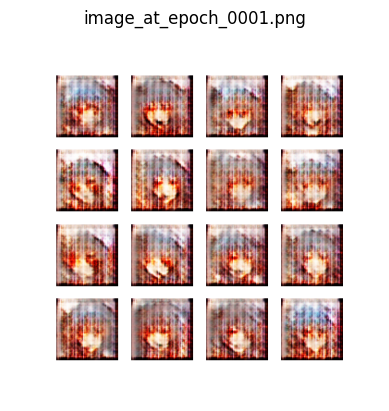

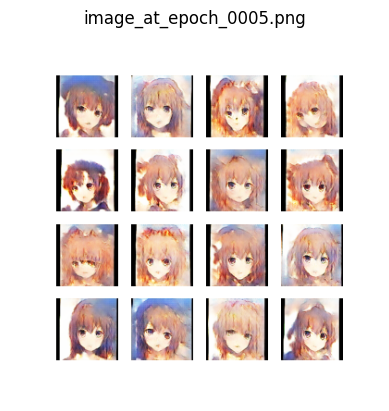

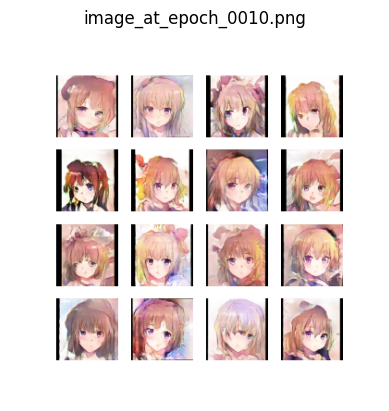

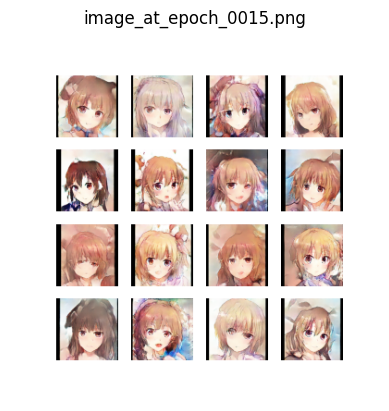

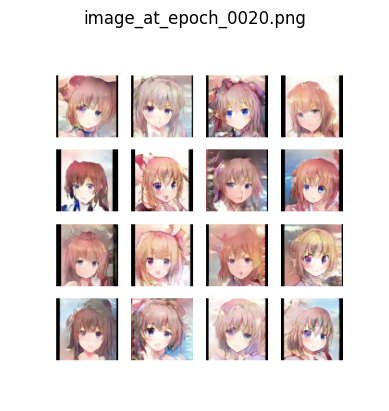

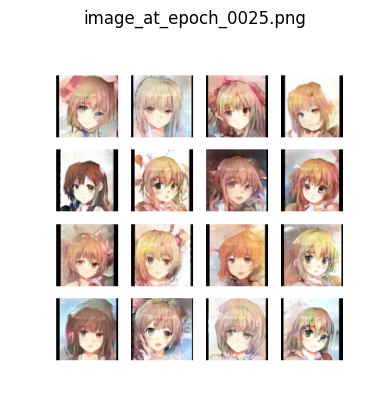

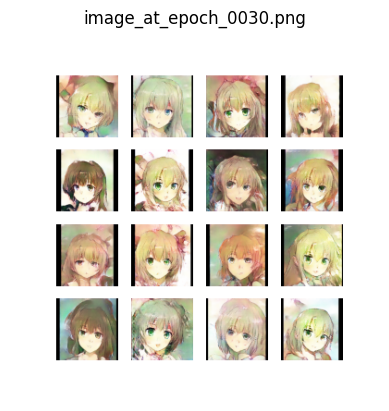

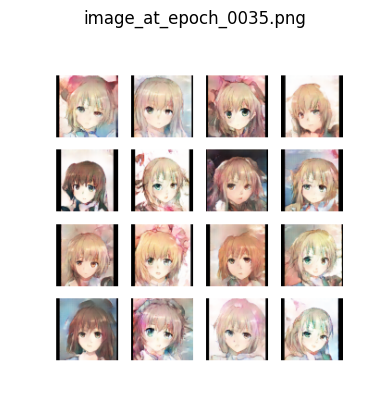

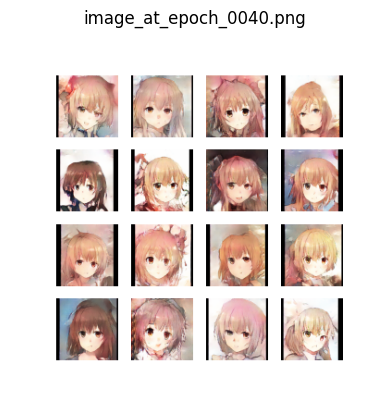

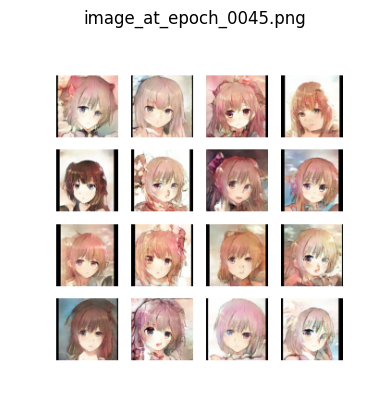

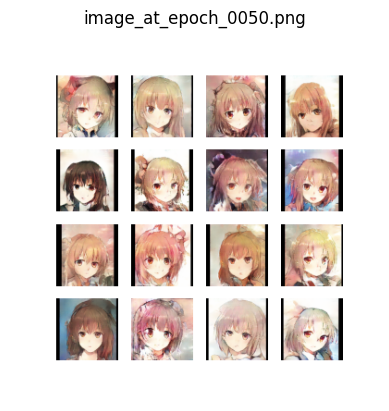

In [5]:
folder_path = 'results/images' 

image_files = sorted(os.listdir(folder_path))

for image_file in image_files:
    if image_file.endswith('.png'):  # Only pick PNG files
        img_path = os.path.join(folder_path, image_file)
        img = Image.open(img_path)

        plt.imshow(img)
        plt.title(image_file)
        plt.axis('off')
        plt.show()